### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import time

from geopy.geocoders import Nominatim
import random
import requests
from bs4 import BeautifulSoup

import plotly.express as px
import plotly.graph_objects as go
import polyline

import networkx as nx
import matplotlib.pyplot as plt

# Data Ingest & Initial Processing

## Data Sourcing
For the purpose of optimizing routes for ski resorts and areas in New York state. The names of these areas are to be parsed from the following website.

[Ski Central]('https://www.skicentral.com/') - A popular site to review popular ski destinations worldwide.

For the purposes of this optimization, we have restricted the area selection to New York state. The state with the most ski resorts and areas in the US. Obtaining these names and their location data is a straight forward procedure.

### Web Scraping (Resort Names)

In [2]:
base_url = "https://www.skicentral.com"
response = requests.get(f"{base_url}/newyork.html")
soup = BeautifulSoup(response.text, 'html.parser')

resort_titles = soup.find_all('div', class_='resorttitle')
resort_names = [title.text.strip() for title in resort_titles]
print(resort_titles)
print(resort_names)

[<div class="resorttitle"><a href="whiteface.html">Whiteface Mountain</a></div>, <div class="resorttitle"><a href="goremountain.html">Gore Mountain</a></div>, <div class="resorttitle"><a href="huntermountain.html">Hunter Mountain</a></div>, <div class="resorttitle"><a href="belleayre.html">Belleayre Mountain</a></div>, <div class="resorttitle"><a href="holidayvalley.html">Holiday Valley</a></div>, <div class="resorttitle"><a href="skiwindham.html">Windham Mountain</a></div>, <div class="resorttitle"><a href="greekpeak.html">Greek Peak</a></div>, <div class="resorttitle"><a href="catamount.html">Catamount Ski Area</a></div>, <div class="resorttitle"><a href="peeknpeak.html">Peek'n Peak Resort</a></div>, <div class="resorttitle"><a href="holimont.html">HoliMont</a></div>, <div class="resorttitle"><a href="beartownskiarea.html">Beartown Ski Area</a></div>, <div class="resorttitle"><a href="brantlingskiandsnowboardcenter.html">Brantling Ski and Snowboard Center</a></div>, <div class="resor

### Parse and collect resort data
In order to obtain the mountain statistics located a link deep at each of the `resort_item`s, we must find the associated hyperlink. There is no universal formatting for how the links are named throughout the resort items, so obtaining the link directly in this fashion is necessary over determining it directly from the resort name.

In [3]:
resorts = []
for title in resort_titles:
    link = title.find('a')
    resort_url = base_url + "/" + link.get('href')
    resorts.append({
    'name': title.text.strip(),
    'url': resort_url})
    
print(resorts)

[{'name': 'Whiteface Mountain', 'url': 'https://www.skicentral.com/whiteface.html'}, {'name': 'Gore Mountain', 'url': 'https://www.skicentral.com/goremountain.html'}, {'name': 'Hunter Mountain', 'url': 'https://www.skicentral.com/huntermountain.html'}, {'name': 'Belleayre Mountain', 'url': 'https://www.skicentral.com/belleayre.html'}, {'name': 'Holiday Valley', 'url': 'https://www.skicentral.com/holidayvalley.html'}, {'name': 'Windham Mountain', 'url': 'https://www.skicentral.com/skiwindham.html'}, {'name': 'Greek Peak', 'url': 'https://www.skicentral.com/greekpeak.html'}, {'name': 'Catamount Ski Area', 'url': 'https://www.skicentral.com/catamount.html'}, {'name': "Peek'n Peak Resort", 'url': 'https://www.skicentral.com/peeknpeak.html'}, {'name': 'HoliMont', 'url': 'https://www.skicentral.com/holimont.html'}, {'name': 'Beartown Ski Area', 'url': 'https://www.skicentral.com/beartownskiarea.html'}, {'name': 'Brantling Ski and Snowboard Center', 'url': 'https://www.skicentral.com/brantlin

Once the link to each of the specified mountain pages have been collected, they are organized by name and url in a dictionary by making the link object into an iteratable object with the if statement.

In [4]:
geolocator = Nominatim(user_agent="DCJT3_NY_SKI")

for resort in resorts:
    location = geolocator.geocode(f"{resort['name']}, NY")
    if location:
        resort['latitude'] = location.latitude
        resort['longitude'] = location.longitude
        resort['address'] = location.address

    # Mountain stats scrape
    response = requests.get(resort['url'])
    resort_soup = BeautifulSoup(response.text, 'html.parser')
    stats_table = resort_soup.find('table', id='mountainstatistics')

    for row in stats_table.find_all('tr'):
        cols = row.find_all(['td', 'th'])
        if len(cols) == 2:
            stat_name = cols[0].text.strip().lower().replace(' ', '_')
            stat_value = cols[1].text.strip()
            resort[stat_name] = stat_value
    
time.sleep(1)

df = pd.DataFrame(resorts)
df.head()

,name,url,latitude,longitude,address,vertical_rise,base_elevation,summit_elevation,annual_snowfall,number_of_trails,skiable_acres,longest_run,snowmaking
0,Whiteface Mountain,https://www.skicentral.com/whiteface.html,44.365784,-73.902984,"Whiteface Mountain, Essex County, New York, Un...",3430 ft,1220 ft,4650 ft,190 inches,90,288,2.1 miles / 3.4 km,98%
1,Gore Mountain,https://www.skicentral.com/goremountain.html,43.672954,-74.048853,"Gore Mountain, Town of Johnsburg, Warren Count...",2537 ft,998 ft,3600 ft,150 inches,107,439,4.4 miles / 7.1 km,97%
2,Hunter Mountain,https://www.skicentral.com/huntermountain.html,42.177866,-74.230422,"Hunter Mountain, Town of Hunter, Greene County...",1600 ft,1600 ft,3200 ft,125 inches,58,240,n/a,100%
3,Belleayre Mountain,https://www.skicentral.com/belleayre.html,42.126893,-74.474075,"Belleayre Mountain Day Use Area, Pine Hill, To...",1404 ft,2025 ft,3429 ft,141 inches,50,171,n/a,96%
4,Holiday Valley,https://www.skicentral.com/holidayvalley.html,42.263145,-78.663611,"Holiday Valley, Town of Ellicottville, Cattara...",750 ft,1500 ft,2250 ft,180 inches,58,290,0.8 miles / 1.3 km,95%


# Data Description

- **name**: name of the resort as it appears on the web source.
- **url**: URL of the resort or ski area as presented on the web source.
- **vertical_rise**: a measurement of the total elevation change a skier descends from the highest point to the lowest point on a ski run.
- **base_elevation**: a measurment of the altitude at the bottom of the ski resort or ski area, essentially the lowest point of on the mountain accessable to skiers.
- **summit_elevation**: a measurement of the height above sea level of the highest point on a mountain.
- **annual_snowfall**: the total amount of snow that falls over the course of a year.
- **number_of_trails**: the total number of trails on the mountain
- **skiable_acres**: the amount of terrain that is accessible by ski.
- **longest_run**: a measurement refering to a continuous downhill ski slope that covers the greatest distance from top to bottom on a mountain.
- **snowmaking**: a measurement or indication that the ski resort or area creates artifical snow for the purpose producing snow when natural snowfall is limited.
- **latitude**: decimal latitude of resort location.
- **longitude**: decimal longitude of resort location.
- **address**: geolocated address based on query "`name`, NY".

# Data Processing

In [5]:
df_clean = df.dropna(subset=['latitude', 'longitude'])
df_clean['vertical_rise_num'] = df_clean['vertical_rise'].str.replace(' ft', '').astype(float)
df_filtered = df_clean[df_clean['name'] != 'HoliMont'] # removed, too close to Holiday Valley (higher elevation)
top_9 = df_filtered.head(9)
top_9

/tmp/ipykernel_111716/1675859879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['vertical_rise_num'] = df_clean['vertical_rise'].str.replace(' ft', '').astype(float)


,name,url,latitude,longitude,address,vertical_rise,base_elevation,summit_elevation,annual_snowfall,number_of_trails,skiable_acres,longest_run,snowmaking,vertical_rise_num
0,Whiteface Mountain,https://www.skicentral.com/whiteface.html,44.365784,-73.902984,"Whiteface Mountain, Essex County, New York, Un...",3430 ft,1220 ft,4650 ft,190 inches,90,288,2.1 miles / 3.4 km,98%,3430.0
1,Gore Mountain,https://www.skicentral.com/goremountain.html,43.672954,-74.048853,"Gore Mountain, Town of Johnsburg, Warren Count...",2537 ft,998 ft,3600 ft,150 inches,107,439,4.4 miles / 7.1 km,97%,2537.0
2,Hunter Mountain,https://www.skicentral.com/huntermountain.html,42.177866,-74.230422,"Hunter Mountain, Town of Hunter, Greene County...",1600 ft,1600 ft,3200 ft,125 inches,58,240,n/a,100%,1600.0
3,Belleayre Mountain,https://www.skicentral.com/belleayre.html,42.126893,-74.474075,"Belleayre Mountain Day Use Area, Pine Hill, To...",1404 ft,2025 ft,3429 ft,141 inches,50,171,n/a,96%,1404.0
4,Holiday Valley,https://www.skicentral.com/holidayvalley.html,42.263145,-78.663611,"Holiday Valley, Town of Ellicottville, Cattara...",750 ft,1500 ft,2250 ft,180 inches,58,290,0.8 miles / 1.3 km,95%,750.0
5,Windham Mountain,https://www.skicentral.com/skiwindham.html,42.293926,-74.261312,"Windham Mountain Club, Town of Windham, Greene...",1600 ft,1500 ft,3100 ft,105 inches,54,285,n/a,97%,1600.0
6,Greek Peak,https://www.skicentral.com/greekpeak.html,42.502320,-76.148046,"Greek Peak Mountain Resort, 2000, South Hill R...",952 ft,1148 ft,2100 ft,122 inches,38,220,1.5 miles / 2.4 km,83%,952.0
8,Peek'n Peak Resort,https://www.skicentral.com/peeknpeak.html,42.060463,-79.744066,"Peek'n Peak Resort, Abbey Lane, Town of French...",400 ft,1400 ft,1800 ft,200 inches,27,105,0 miles / 1 km,100%,400.0
10,Beartown Ski Area,https://www.skicentral.com/beartownskiarea.html,44.764111,-73.584055,"Beartown Ski Area, Beartown Road, Beartown, To...",150 ft,n/a,n/a,n/a,9,n/a,n/a,yes,150.0


In [6]:
fig = px.scatter_mapbox(df_filtered[:9], 
                       lat='latitude', 
                       lon='longitude',
                       hover_name='name',
                       zoom=5,
                       mapbox_style='carto-positron')

# Update the layout to center on NY
fig.update_layout(
    title='Selected New York Ski Resorts',
    mapbox=dict(
        center=dict(lat=43.2994, lon=-74.2179)  # Center of NY State
    ),
    margin=dict(l=0, r=0, t=30, b=0)
)

fig.show()

# Exploratory Data Analysis

# Random Route Generator

In [7]:
def osrm_route(start_point, end_point):
    osrm_url = f"http://router.project-osrm.org/route/v1/driving/{start_point[1]},{start_point[0]};{end_point[1]},{end_point[0]}"
    response = requests.get(osrm_url)
    
    data = response.json()
    if data["code"] == "Ok":
        return {
            'distance': data["routes"][0]["distance"] / 1000 * 0.621371,  # meters to miles
            'geometry': data["routes"][0]["geometry"]
        }
    return None

In [8]:
def random_route_gen(df):
    random.seed(12345)

    # find index with lowest vertical rise (start off somewhere comparably safe)
    start_idx = df['vertical_rise_num'].idxmin()
    start_pos = df.index.get_loc(start_idx)

    locations = list(range(len(df))) # create list of indexes 
    locations.remove(start_pos)
    route = [start_pos] + random.sample(locations, len(locations)) # randomly sample from list

    total_distance = 0
    all_route_points = []
    route_details = []

    for i in range(len(route)-1):
        start = df.iloc[route[i]]
        end = df.iloc[route[i+1]]

        route_data = osrm_route(
            (start['latitude'], start['longitude']),
            (end['latitude'], end['longitude'])
        )

        total_distance += route_data['distance']
        decoded_points = polyline.decode(route_data['geometry'])
        all_route_points.append(decoded_points)
        route_details.append({
            'from': start['name'],
            'to': end['name'],
            'distance': route_data['distance']})

    fig = go.Figure()

    # Add route lines
    for points in all_route_points:
        lat, lon = zip(*points)
        fig.add_trace(go.Scattermapbox(
            lon=lon,
            lat=lat,
            mode='lines',
            line=dict(width=1, color='blue'),
            hoverinfo='skip'
        ))

    # Add resort markers
    resort_lat = []
    resort_lon = []
    resort_names = []
    for i, idx in enumerate(route):
        location = df.iloc[idx]
        resort_lat.append(location['latitude'])
        resort_lon.append(location['longitude'])
        resort_names.append(f"Stop {i+1}: {location['name']}")

    fig.add_trace(go.Scattermapbox(
        lon=resort_lon,
        lat=resort_lat,
        mode='markers',
        marker=dict(size=12, color='red'),
        text=resort_names,
        name="Ski Resort"
    ))

    # Update layout
    fig.update_layout(
        title='New York Ski Resort - Random Route',
        mapbox=dict(
            style="carfig.write_html('computation_time_comparison.html')istance: {total_distance} miles")

    return fig, total_distance, route_details

In [9]:
%%time
fig, total_dist, route_details = random_route_gen(top_9)

1. Beartown Ski Area
2. Greek Peak
3. Windham Mountain
4. Whiteface Mountain
5. Hunter Mountain
6. Holiday Valley
7. Peek'n Peak Resort
8. Gore Mountain
9. Belleayre Mountain

Total Distance: 1718.5590180485 miles
CPU times: user 59.5 ms, sys: 6.86 ms, total: 66.4 ms
Wall time: 3.82 s


In [10]:
fig.show()

In [11]:
fig.write_html('random_route1_full.html', full_html=True)
fig.write_html('random_route1.html', full_html=False)

# Optimized Route (Directed Graph Distance Minimization)

Network Statistics:
--------------------------------------------------
Starting Resort: Beartown Ski Area (Vertical Rise: 150 ft)
Number of Resorts (Nodes): 9
Number of Possible Routes (Edges): 72


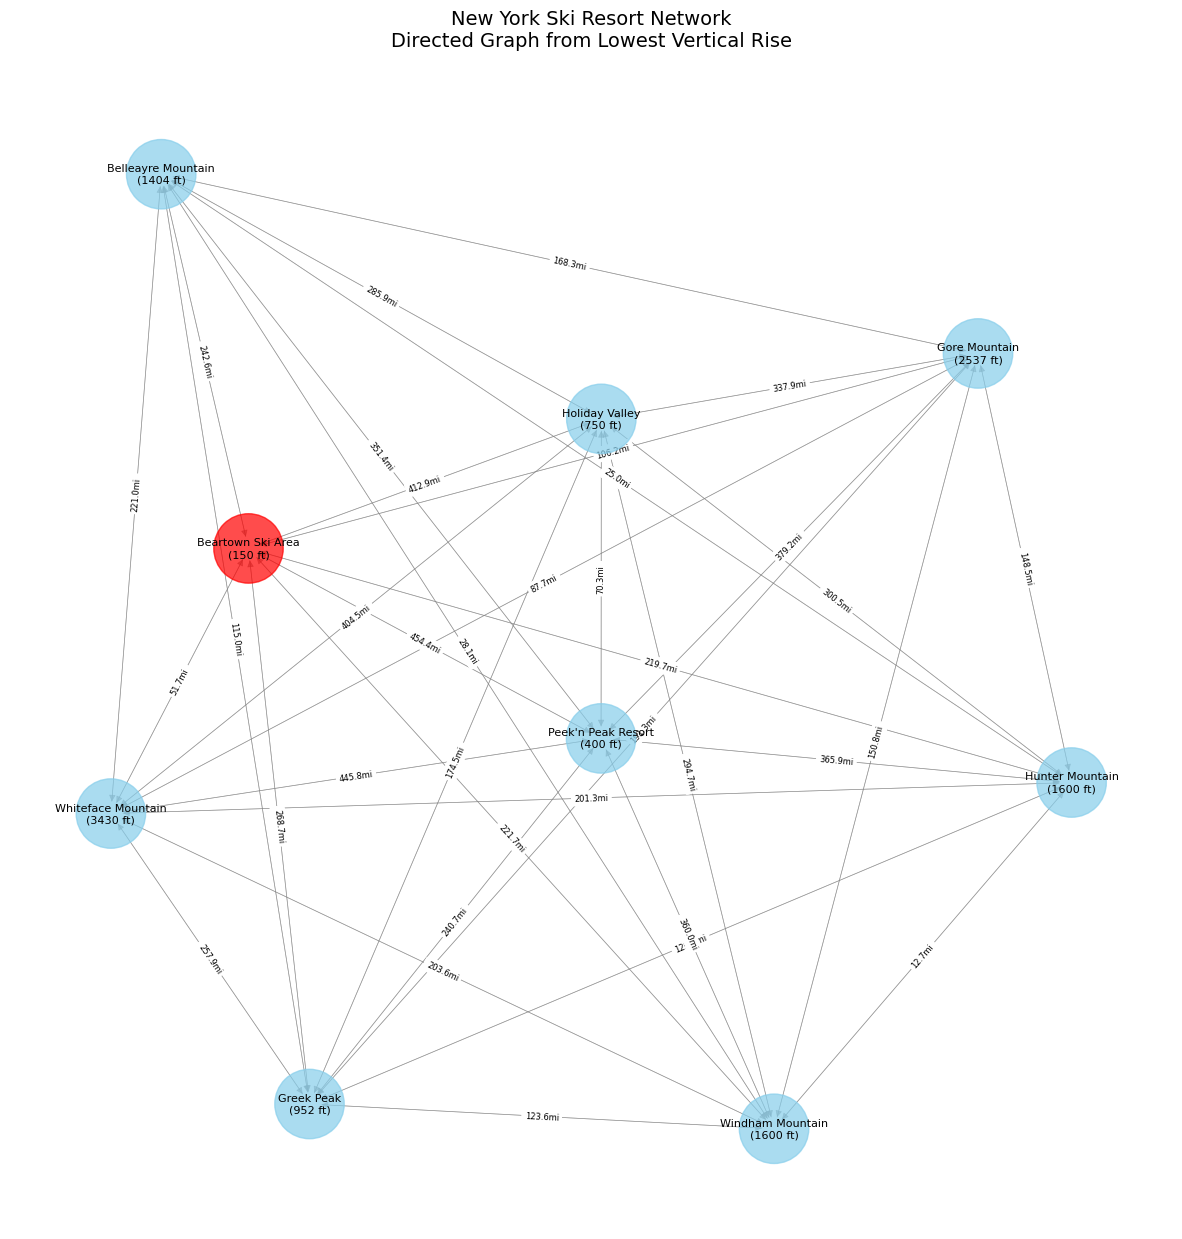

In [12]:
def visualize_ski_network_from_start(df):
    # Create directed graph
    G = nx.DiGraph()
    
    # Find starting point (lowest vertical rise)
    start_idx = df['vertical_rise_num'].idxmin()
    
    # Add nodes (ski resorts)
    for idx, resort in df.iterrows():
        G.add_node(idx, 
                  name=resort['name'],
                  vertical_rise=resort['vertical_rise'])
    
    # Add edges from all points to all other points
    for i in df.index:
        for j in df.index:
            if i != j:  # Do not connect to self
                start = df.loc[i]
                end = df.loc[j]
                route_data = osrm_route(
                    (start['latitude'], start['longitude']),
                    (end['latitude'], end['longitude'])
                )
                G.add_edge(i, j, weight=route_data['distance']) # obtain distance from osrm api and create weight
    
    # Create visualization
    plt.figure(figsize=(15, 15))
    
    # Set layout
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw nodes
    node_colors = ['red' if node == start_idx else 'skyblue' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=2500,
                          alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          width=0.5,
                          alpha=0.6,
                          arrows=True,
                          arrowsize=10)
    
    # Add node labels
    labels = {node: f"{G.nodes[node]['name']}\n({G.nodes[node]['vertical_rise']})" 
             for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Add edge labels (distances)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {(u,v): f'{w:.1f}mi' for (u,v,w) in G.edges(data='weight')}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
    
    plt.title("New York Ski Resort Network\nDirected Graph from Lowest Vertical Rise", 
              pad=20, fontsize=14)
    plt.axis('off')
    
    # Print network statistics
    print("Network Statistics:")
    print("-" * 50)
    print(f"Starting Resort: {df.loc[start_idx]['name']} (Vertical Rise: {df.loc[start_idx]['vertical_rise']})")
    print(f"Number of Resorts (Nodes): {G.number_of_nodes()}")
    print(f"Number of Possible Routes (Edges): {G.number_of_edges()}")
    
    return G, plt.gcf()

G, fig = visualize_ski_network_from_start(top_9)
plt.show()

The algorithm below builds a route with a start at the lowest `vertical_rise`, this allows uniformity between the random and optimized comparisons. Utilizing the graph information from the DiGraph created earlier, we can determine the appropriate route which minimizes the distance traveled.

While making sure that the next node is within the unvisited set, the next node is decided based on a comparison of all the available distances from a particular node. In this case we want to select the minimal distance. In the least distance route, this is determined through a dictionary search of unvisited nodes and their respective distances or weights.

Once the minmum distance between two nodes in the univsited set is determined the route list is appended, this continues for as long as there is a an unvisited node. Once all the nodes have been visited and the minimal distance total is calculated. We insure that the loop is left open/ceased.

In [13]:
def least_distance_route(G, df):
    # Get starting point (lowest vertical rise)
    start_idx = df['vertical_rise_num'].idxmin()
    
    # Initialize variables
    unvisited = set(G.nodes()) - {start_idx}  # Use the actual node indices from the directed graph
    current = start_idx
    route = [current]
    total_distance = 0
    
    # Core Nearest Neighbor loop
    while unvisited:
        # Find distances to unvisited neighbors
        next_distances = {node: G[current][node]['weight'] 
                        for node in unvisited}
        
        # Select closest unvisited neighbor
        next_node = min(next_distances, key=next_distances.get)
        distance = next_distances[next_node]
        
        # Update route
        route.append(next_node)
        total_distance += distance
        current = next_node
        unvisited.remove(current)
    
    return route, total_distance

To reiterate the strategy of utilizing the previous graph network. It is designed to capture all distance information determined from the OSRM measurements between all points. Making sure to define the starting point (lowest vertical rise) we determine the next point by getting the minimal distance option, and so on. Once a point is selected as the `next_node` it is selected as the current node and the procedure is repeated until there are no more nodes to travel to; given that we can only visit each node once.

In [14]:
def visualize_ld_route(df, route):
    all_route_points = []
    
    # Get route geometries from osrm API
    for i in range(len(route)-1):
        start = df.loc[route[i]]
        end = df.loc[route[i+1]]
        
        route_data = osrm_route(
            (start['latitude'], start['longitude']),
            (end['latitude'], end['longitude'])
        )
        decoded_points = polyline.decode(route_data['geometry'])
        all_route_points.append(decoded_points)
    
    # Create figure
    fig = go.Figure()
    
    # Add route lines
    for points in all_route_points:
        lat, lon = zip(*points)
        fig.add_trace(go.Scattermapbox(
            lon=lon,
            lat=lat,
            mode='lines',
            line=dict(width=2, color='blue'),
            hoverinfo='skip'
        ))
    
    # Add resort markers
    resort_lat = []
    resort_lon = []
    resort_names = []
    for i, idx in enumerate(route):
        location = df.loc[idx]    # Changed from iloc to loc
        resort_lat.append(location['latitude'])
        resort_lon.append(location['longitude'])
        resort_names.append(f"Stop {i+1}: {location['name']}")
    
    fig.add_trace(go.Scattermapbox(
        lon=resort_lon,
        lat=resort_lat,
        mode='markers',
        marker=dict(size=12, color=['red' if i == 0 else 'lightblue' for i in range(len(route))]),
        text=resort_names,
        name='Ski Resorts'
    ))
    
    fig.update_layout(
        title='New York Ski Resort - Optimized Route',
        mapbox=dict(
            style="carto-positron",
            center=dict(lat=np.mean(resort_lat), lon=np.mean(resort_lon)),
            zoom=5
        ),
        showlegend=False,
        margin=dict(l=0, r=0, t=30, b=0)
    )
    
    return fig

In [15]:
%%time
route, total_distance = least_distance_route(G, top_9)

CPU times: user 486 μs, sys: 36 μs, total: 522 μs
Wall time: 510 μs


In [16]:
fig = visualize_ld_route(top_9, route)
fig.show()

print(total_distance, "miles")

688.4506713453 miles


In [17]:
fig.write_html('optimized_route1_full.html', full_html=True)
fig.write_html('optimized_route1.html', full_html=False)

# Compute time comparison

The computation times between random and optimized routing techniques is due to the fact that the random_route handles the plotting via the OSRM API calls needed to gather the geometries of the routes between points. While the optimized route is simply solving a Digraph problem, where it selects the minimal edge weight.

In [22]:
fig = go.Figure(data=[
    go.Bar(
        x=['Random Route', 'Optimized Route'],
        y=[4.48, 0.000757],
        marker_color=['#121314', '#28B463'],
        text=[f'{4.48:.2f}s', f'{0.000757:.6f}s'],
        textposition='auto',
    )
])

# Update layout
fig.update_layout(
    title='Route Computation Time Comparison',
    yaxis_title='Time (seconds) log',
    template='plotly_white',
    showlegend=False,
    yaxis_type='log'  # Log scaling needed for visualization
)

# Show figure
fig.show()

In [23]:
fig.write_html('computation_time_comparison.html')